<link rel="stylesheet" href="/mediapipe/site.css">

# Hand gesture recognition model: Hyperparameter Tuning

> Reference: Hand gesture recognition model customization guide

<table align="left" class="buttons">
  <td>
    <a href="https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/customization/gesture_recognizer.ipynb" target="_blank">
      <img src="https://developers.google.com/static/mediapipe/solutions/customization/colab-logo-32px_1920.png" alt="Colab logo"> Original page in Colab
    </a>
  </td>

  <td>
    <a href="https://github.com/googlesamples/mediapipe/blob/main/examples/customization/gesture_recognizer.ipynb" target="_blank">
      <img src="https://developers.google.com/static/mediapipe/solutions/customization/github-logo-32px_1920.png" alt="GitHub logo">
      Original page on GitHub
    </a>
  </td>
</table>

## Prerequisites

Install the MediaPipe Model Maker package.

In [ ]:
!pip install --upgrade pip
!pip install mediapipe-model-maker

Import the required libraries.

In [2]:
from google.colab import files
import os
import tensorflow as tf
assert tf.__version__.startswith('2')
import shutil

from mediapipe_model_maker import gesture_recognizer

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Preparing Dataset

The dataset for gesture recognition in model maker requires the following format: `<dataset_path>/<label_name>/<img_name>.*`. In addition, one of the label names (`label_names`) must be `none`. The `none` label represents any gesture that isn't classified as one of the other gestures.

This example uses a partial dataset sample.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget https://github.com/Shadowfax221/553.806_Capstone_HandGesture/blob/main/minor_dataset.zip
!unzip /content/drive/MyDrive/Colab/dataset_selected1000.zip

In [5]:
dataset_path = "dataset_selected"
print(dataset_path)
labels = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
print(labels)

dataset_selected
['like', 'stop', 'stop_inverted', 'fist', 'palm', 'call', 'one', 'peace', 'dislike', 'ok', 'rock', 'mute', 'none']


## Modeling

**Load the dataset**

Load the dataset located at `dataset_path` by using the `Dataset.from_folder` method. When loading the dataset, run the pre-packaged hand detection model from MediaPipe Hands to detect the hand landmarks from the images. Any images without detected hands are ommitted from the dataset. The resulting dataset will contain the extracted hand landmark positions from each image, rather than images themselves.

The `HandDataPreprocessingParams` class contains two configurable options for the data loading process:
* `shuffle`: A boolean controlling whether to shuffle the dataset. Defaults to true.
* `min_detection_confidence`: A float between 0 and 1 controlling the confidence threshold for hand detection.

Split the dataset: 80% for training, 10% for validation, and 10% for testing.

In [6]:
data = gesture_recognizer.Dataset.from_folder(
    dirname=dataset_path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

**Training**

Define a function for training and evaluation.

In [22]:
def train_and_evaluate(layer_widths=[], learning_rate=0.001, dropout_rate=0.05, batch_size=2, epochs=10):
    hparams = gesture_recognizer.HParams(
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs,
        export_dir="exported_model"
    )
    model_options = gesture_recognizer.ModelOptions(
        dropout_rate=dropout_rate,
        layer_widths=layer_widths
    )
    options = gesture_recognizer.GestureRecognizerOptions(
        model_options=model_options,
        hparams=hparams
    )
    model = gesture_recognizer.GestureRecognizer.create(
        train_data=train_data,
        validation_data=validation_data,
        options=options
    )
    loss, acc = model.evaluate(test_data, batch_size=1)
    print(f"Layer widths: {layer_widths}, Loss: {loss}, Accuracy: {acc}")

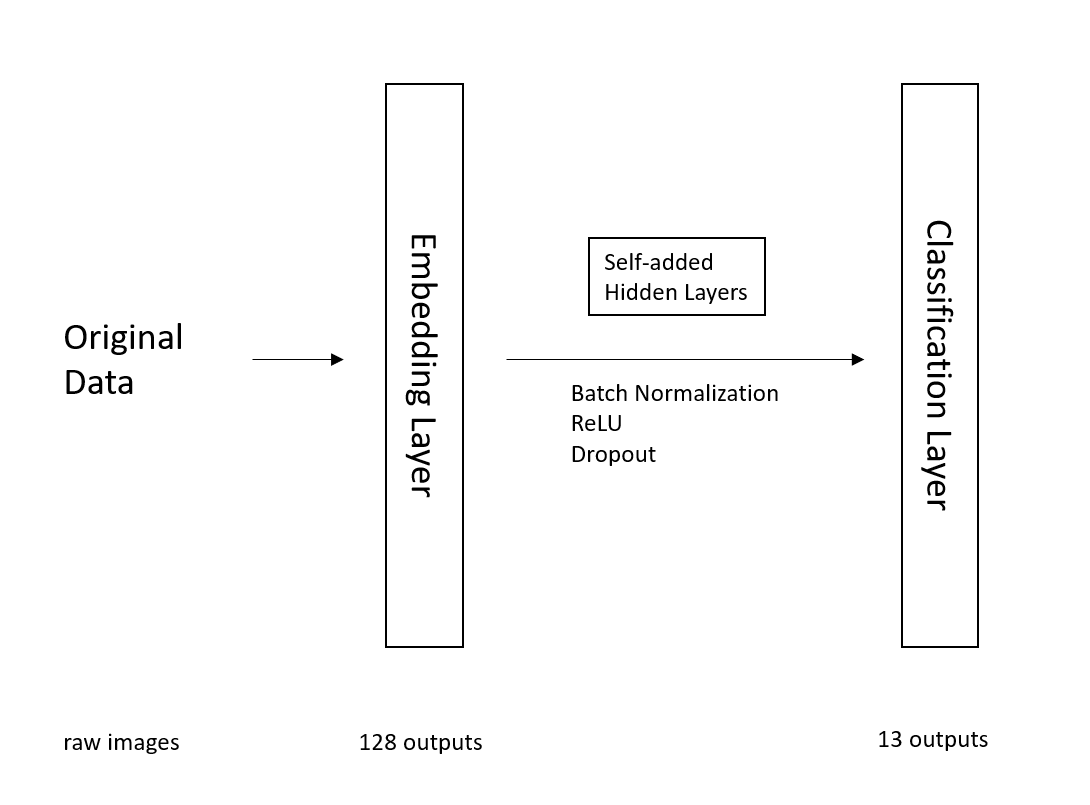

## Hyperparameter Tuning

We can further customize the model using the `GestureRecognizerOptions` class, which has two optional parameters for `ModelOptions` and `HParams`. Use the `ModelOptions` class to customize parameters related to the model itself, and the `HParams` class to customize other parameters related to training and saving the model.

`ModelOptions` has one customizable parameter that affects accuracy:
* `dropout_rate`: The fraction of the input units to drop. Used in dropout layer. Defaults to 0.05.
* `layer_widths`: A list of hidden layer widths for the gesture model. Each element in the list will create a new hidden layer with the specified width. The hidden layers are separated with BatchNorm, Dropout, and ReLU. Defaults to an empty list(no hidden layers).

`HParams` has the following list of customizable parameters which affect model accuracy:
* `learning_rate`: The learning rate to use for gradient descent training. Defaults to 0.001.
* `batch_size`: Batch size for training. Defaults to 2.
* `epochs`: Number of training iterations over the dataset. Defaults to 10.
* `steps_per_epoch`: An optional integer that indicates the number of training steps per epoch. If not set, the training pipeline calculates the default steps per epoch as the training dataset size divided by batch size.
* `shuffle`: True if the dataset is shuffled before training. Defaults to False.
* `lr_decay`: Learning rate decay to use for gradient descent training. Defaults to 0.99.
* `gamma`: Gamma parameter for focal loss. Defaults to 2

Additional `HParams` parameter that does not affect model accuracy:
* `export_dir`: The location of the model checkpoint files and exported model files.

In [21]:
def delete_exported():
   folder_path = '/content/exported_model'
   if os.path.exists(folder_path):
      shutil.rmtree(folder_path)

### Network Shape

In [17]:
# Try different structures configurations
layer_configs = [
    [],
    [64],
]


In [18]:
for config in layer_configs:
   print("Training and evaluating for layer config: ", config)
   delete_exported()
   train_and_evaluate(layer_widths=config)

Training and evaluating for layer config:  []
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer  [(None, 128)]             0         
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 custom_gesture_recognizer_  (None, 13)                1677      
 out (Dense)                                                     
               

The default network shape has the best performance.

### Dropout Rate

In [23]:
dropout_configs = [
    0,
    0.05,
    0.1,
    0.2
]

In [26]:
for config in dropout_configs:
   print("Training and evaluating for dropout rate: ", config)
   delete_exported()
   train_and_evaluate(dropout_rate=config)

Training and evaluating for dropout rate:  0
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer  [(None, 128)]             0         
 )                                                               
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 128)               0         
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 custom_gesture_recognizer_  (None, 13)                1677      
 out (Dense)                                                     
              

The Dropout Rate 0.2 has the best performance, while it reduces overfitting.

### Batch Size

In [27]:
batch_size_configs = [
    2,
    10,
    100
]

In [28]:
for config in batch_size_configs:
   print("Training and evaluating for batch size: ", config)
   delete_exported()
   train_and_evaluate(dropout_rate=0.2, batch_size=config)

Training and evaluating for batch size:  1
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer  [(None, 128)]             0         
 )                                                               
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 re_lu_8 (ReLU)              (None, 128)               0         
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 custom_gesture_recognizer_  (None, 13)                1677      
 out (Dense)                                                     
                

The batch-size 10 (1% of the data) has the best performance.